MPI Interior Eigensolve with Lazy, Projected Operators
=========================

This example demonstrates some 'advanced' methods for diagonalizing large Hamiltonians.

First of all, assuming we are using ``slepc4py``, we can specify the 'arch' we want to use. In this case, there is an optimized version of 'petsc' and 'slepc', compiled with float scalars, named `'arch-auto-real'`:

In [1]:
# optional - comment or ignore this cell to use the default arch
#     or specify your own arch
import os
os.environ['PETSC_ARCH'] = 'arch-auto-real'

For real problems (like below) this generally gives a bit of a speed boost. After doing that we can import `quimb`:

In [2]:
import quimb as qu

We are not going to contsruct the Hamiltonian directly, instead leave it as a `Lazy` object, so that each MPI process can construct its own rows and avoid redudant communication and memory. To do that we need to know the size of the matrix first:

In [3]:
# total hilbert space for 18 spin-1/2s
n = 18
d = 2**n
shape = (d, d)

# And make the lazy representation
H_opts = {'n': n, 'dh': 3.0, 'sparse': True, 'seed': 9}
H = qu.Lazy(qu.ham_mbl, **H_opts, shape=shape)
H

<Lazy(ham_mbl, shape=(262144, 262144))>

This Hamiltonian also conserves z-spin, which we can use to make the effective problem significantly smaller. This is done by supplying a projector onto the subspace we are targeting. We also need to know its size first if we want to leave it 'unconstructed':

In [4]:
# total Sz=0 subspace size (n choose n / 2)
from scipy.special import comb

ds = comb(n, n // 2, exact=True)
shape = (d, ds)

# And make the lazy representation
P = qu.Lazy(qu.zspin_projector, n=n, shape=shape)
P

<Lazy(zspin_projector, shape=(262144, 48620))>

Now we can solve the hamiltoniain, for 5 eigenpairs centered around energy `0`:

In [5]:
%%time
lk, vk = qu.eigh(H, P=P, k=5, sigma=0.0, backend='slepc')
print('energies:', lk)

energies: [-9.10482079e-04 -7.21481890e-04 -2.40962026e-04 -1.77843488e-04
 -5.45274570e-05]
CPU times: user 292 ms, sys: 182 ms, total: 474 ms
Wall time: 14.1 s


`eigh` takes care of projecting `H` into the subspace ($\tilde{H} = P^{\dagger} H P$), and mapping the eigenvectors back the computation basis once found.

Here we specified the `'slepc'` backend. In an interactive session, this will spawn the MPI workers for you (using `mpi4py`). Other options would be to run this in a script using  ``quimb-mpi-python`` which would pro-actively spawn workers from the get-go, and ``quimb-mpi-python --syncro`` which is the more traditional 'syncronised' MPI mode. These modes would be more suitable for a cluster and large problems (see `docs/examples/ex_mpi_expm_evo.py`).

Now we have the 5 eigenpairs, we can compute the 'entanglement matrix' for each, with varying block size. However, seeing as we have a pool of MPI workers already, let's also reuse it to parallelize the computation:

In [6]:
# get an MPI executor pool
pool = qu.linalg.mpi_launcher.get_mpi_pool()

# 'submit' the function with args to the pool
e_k_b_ij = [[pool.submit(qu.ent_cross_matrix, vk[:, [k]], sz_blc=b)
             for b in [1, 2, 3, 4]]
            for k in range(5)]

e_k_b_ij

[[<Future at 0x7f93354b96d8 state=running>,
  <Future at 0x7f9302eef1d0 state=running>,
  <Future at 0x7f9302ed8f60 state=running>,
  <Future at 0x7f9302eef0f0 state=running>],
 [<Future at 0x7f9302eef2e8 state=pending>,
  <Future at 0x7f9302eef240 state=pending>,
  <Future at 0x7f9302eef3c8 state=pending>,
  <Future at 0x7f9302eef438 state=pending>],
 [<Future at 0x7f9302eef4a8 state=pending>,
  <Future at 0x7f9302eef518 state=pending>,
  <Future at 0x7f9302eef588 state=pending>,
  <Future at 0x7f9302eef5f8 state=pending>],
 [<Future at 0x7f9302eef668 state=pending>,
  <Future at 0x7f9302eef6d8 state=pending>,
  <Future at 0x7f9302eef748 state=pending>,
  <Future at 0x7f9302eef7b8 state=pending>],
 [<Future at 0x7f9302eef828 state=pending>,
  <Future at 0x7f9302eef898 state=pending>,
  <Future at 0x7f9302eef940 state=pending>,
  <Future at 0x7f9302eef9e8 state=pending>]]

Once we have submitted all this work to the pool (which works in any of the modes described above), we can retrieve the results:

In [7]:
# convert each 'Future' into its result
e_k_b_ij = [[f.result()
             for f in e_b_ij]
            for e_b_ij in e_k_b_ij]

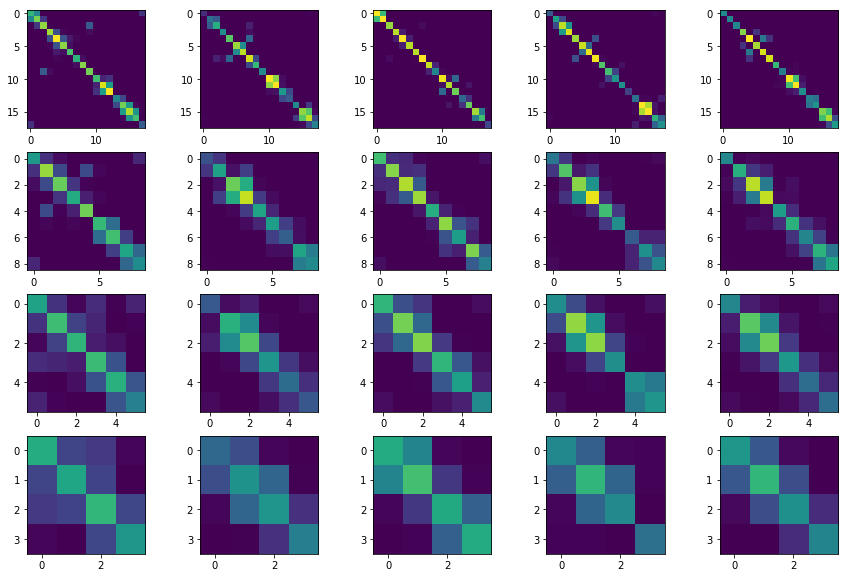

In [8]:
%matplotlib inline

from matplotlib import pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(15, 10), squeeze=True)

for k in range(5):
    for b in [1, 2, 3, 4]:
        e_ij = e_k_b_ij[k][b - 1]
        axes[b - 1, k].imshow(e_ij, vmax=1)

Above, each column is a different spin-z=0 eigenstate, and each row a different blocking. The diagonal of each plot shows the entanglement of each block with its whole environment, and the off-diagonal shows the entanglement with other blocks.